# Th analysis

In [1]:
%matplotlib inline

import os
import random
import sys
import textwrap

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy  as np
import tables as tb

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.paolina_functions as plf

from   collections                             import namedtuple
from   invisible_cities.io.hits_io             import load_hits
from   invisible_cities.io.hits_io             import load_hits_skipping_NN
from   invisible_cities.evm.event_model        import Hit, Cluster, HitCollection
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.types.ic_types         import NN
from   invisible_cities.core.system_of_units_c import units
from   matplotlib.patches                      import Ellipse
from   mpl_toolkits.mplot3d                    import Axes3D

In [111]:
def gaussexpo(x, amp, mu, sigma, const, mean, x0):

    if sigma <= 0.:
        return np.inf
    
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.) + const * np.exp((x-x0)/mean)

# code from Gonzalo
def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (1592/2458)**0.5

def reso_errors(values,errors):
    _, mu, sigma = values
    _, err_mu, err_sigma = errors
    r = 235. * sigma/mu
    err_r = r*np.sqrt((err_sigma/sigma)**2 + (err_mu/mu)**2)
    return err_r, err_r * (1592/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values)))

def gaussexpotext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        $\\bar x$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:3], values[4], *reso(values[0:3])))

## Read the corrections table
Reads the corrections table from the specified file and creates a function that returns the correction factor for a given (x,y) location.

In [3]:
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4168/run4168_corrections.h5"
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/run4446_corrections_5.3mm.h5"
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/run4628_corrections_5.3mm.h5"
ncbins = 74 # 54
tbl_ext = 195.36 # 215

Correction table with shape: (75, 75); bin sizes (5.279998779296875,5.279998779296875)


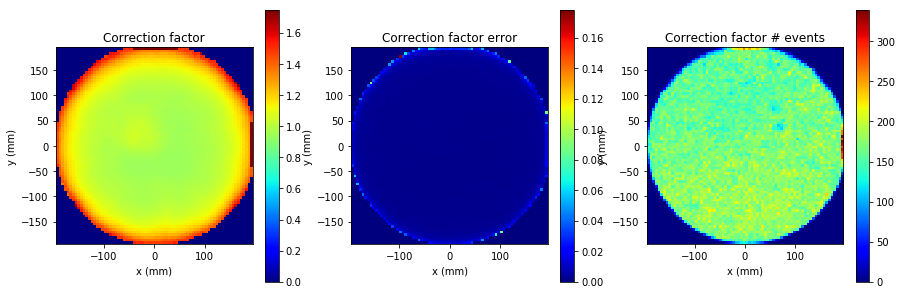

In [4]:
fcorr = tb.open_file(corr_file,'r')

# Fill arrays containing the information in the correction table.
corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf = np.max(corr_fs)

# ---------------------------------------------
# Plots

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor
ax1 = fig.add_subplot(131);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-tbl_ext, tbl_ext), (-tbl_ext, tbl_ext)), weights=corr_fs, cmap='jet', vmin=0, vmax=maxf)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(132)
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-tbl_ext, tbl_ext), (-tbl_ext, tbl_ext)), weights=corr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics
ax3 = fig.add_subplot(133)
ax3.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-tbl_ext, tbl_ext), (-tbl_ext, tbl_ext)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

# get the x and y bin sizes
xdiff = corr_x[1:] - corr_x[0:-1]
nz_xdiff = np.nonzero(xdiff)[0]
xbin = xdiff[nz_xdiff][0]
xcmin = np.min(corr_x)

ydiff = corr_y[1:] - corr_y[0:-1]
nz_ydiff = np.nonzero(ydiff)[0]
ybin = ydiff[np.nonzero(ydiff)][0]
ycmin = np.min(corr_y)

# ---------------------------------------------------
# Create the correction factor table.

ctbl = np.ones([len(nz_xdiff)+1,len(nz_xdiff)+1])-2
for x,y,fs in zip(corr_x,corr_y,corr_fs):
    xb = int((x-xcmin)/xbin)
    yb = int((y-ycmin)/ybin)
    ctbl[xb][yb] = fs
    #print("Filled ({0},{1}) with {2} for x = {3} and y = {4}".format(xb,yb,fs,x,y))
if(len(ctbl[ctbl < 0]) > 0):
    print("ERROR: value in correction table not filled")
print("Correction table with shape: {0}; bin sizes ({1},{2})".format(ctbl.shape,xbin,ybin))

# Define a function that returns the correction factor for a given (x,y).
def fcorr(x,y):
    xb = max(0,min(ctbl.shape[0]-1,((x-xcmin)/xbin).astype(int)))
    yb = max(0,min(ctbl.shape[1]-1,((y-ycmin)/ybin).astype(int)))

    if hasattr(xb, "__len__"):
        cf = [ctbl[xx][yy] for xx,yy in zip(xb,yb)]
        return cf
    else:
        return ctbl[xb][yb]

## Read in the output of Penthesilea
Reads in Penthesilea output from the runs listed

In [5]:
def merge_NN_hits(hits_all,hits_nonNN):

    # Iterate through the nonNN dictionary and update the energies including the NN hits from the "all" dictionary.
    for (evt,hc) in hits_nonNN.items():

        # Get the corresponding collection of all hits.
        hc_all = hits_all[evt]
            
        # Add energy from all NN hits to hits in closest slice.
        for h1 in hc_all.hits:

            if(h1.Q == NN):

                # Find the hits to which the energy will be added.
                zdist_min = -1
                h_add = []
                for h2 in hc.hits:
                    zdist = np.abs(h1.Z - h2.Z)
                    if(zdist_min < 0 or zdist < zdist_min):
                        zdist_min = zdist
                        h_add = []
                        h_add.append(h2)
                    elif(zdist == zdist_min):
                        h_add.append(h2)

                # Add the energy.
                hadd_etot = sum([ha.E for ha in h_add])
                for ha in h_add:
                    ha.energy += h1.E*(ha.E/hadd_etot)
                    
        # Check the sum of the energy.
        #e1 = sum([hh.E for hh in hc_all.hits])
        #e2 = sum([hh.E for hh in hc.hits])
        #if(abs(e1 - e2) > 0.001):
        #    print("ERROR")


In [6]:
# run numbers and lifetime values for correction
l_rnum   = [4595,4597,4599,4601,4603,4605,4607,4609,4611,4613,4615,4617,4619,4621,4623,4625,4627]
l_tlife  = [1387,1438,1456,1460,1455,1463,1478,1488,1479,1501,1505,1496,1507,1514,1533,1544,1550]

# add 50 microseconds to the lifetimes, as it seems to give a flatter z-avg-profile
#for ii in range(len(l_tlife)): l_tlife[ii] += 50

In [7]:
l_hitc = []
for rnum in l_rnum:
    
    fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks_{1}.h5".format(rnum,rnum)
    hits_all = load_hits(fname)
    hits = load_hits_skipping_NN(fname)

    # Modifies the list of non-NN hits.
    merge_NN_hits(hits_all,hits)
    
    # Save the hit collection that no longer contains NN hits.
    l_hitc.append(hits)

In [8]:
# Create the corrected hit collections (summed over all runs) for 
#  fully corrected (c), geometry-only corrected (g), tau-only corrected (t), and uncorrected (u) events.
hitc_uevt = []; hitc_cevt = []; hitc_gevt = []; hitc_tevt = []
for hitc, tlife in zip(l_hitc,l_tlife):

    for ee,hc in hitc.items():
        hc_ucorr = []; hc_corr = []; hc_gcorr = []; hc_tcorr = []
        for hh in hc.hits:
            
            hecorr = hh.E*fcorr(hh.X,hh.Y)/np.exp(-hh.Z/tlife)
            hegcorr = hh.E*fcorr(hh.X,hh.Y)
            hetcorr = hh.E/np.exp(-hh.Z/tlife)
            
            hucorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hh.E)
            hcorr  = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
            hgcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hegcorr)
            htcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hetcorr)
            
            hc_ucorr.append(hucorr); hc_corr.append(hcorr); hc_gcorr.append(hgcorr); hc_tcorr.append(htcorr)
        
        # Only save events with >= 2 hits.
        if(len(hc_corr) >= 2):
            hitc_uevt.append(hc_ucorr)
            hitc_cevt.append(hc_corr)
            hitc_gevt.append(hc_gcorr)
            hitc_tevt.append(hc_tcorr)

---------------------------

# Extraction of main event quantities

In [61]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 500],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([15,15,15],dtype=np.int16)    # voxel size
blob_radius = 21.                    # blob radius in mm

CAL_FACTOR = 1620/486000   # overall energy calibration factor
npmts = 11

evtfname = "228th_arrays_123k_r4628_180917.npz"

## Load the information directly from a file

In [10]:
fn = np.load(evtfname)
A_eblob1 = fn['A_eblob1']
A_eblob2 = fn['A_eblob2']
A_emtrk  = fn['A_emtrk']
A_lmtrk  = fn['A_lmtrk']
A_ntrks  = fn['A_ntrks']
A_nvox   = fn['A_nvox']
A_Ec     = fn['A_Ec']
A_Ec_avg = fn['A_Ec_avg']
A_Ec_tau = fn['A_Ec_tau']
A_Ec_geo = fn['A_Ec_geo']
A_E0     = fn['A_E0']
A_xavg   = fn['A_xavg']
A_yavg   = fn['A_yavg']
A_zavg   = fn['A_zavg']
A_ravg   = fn['A_ravg']

## Paolina step

In [ ]:
# Run Paolina for many events: note we now assume that all events have >= 2 hits
A_eblob1 = []; A_eblob2 = []; A_emtrk = []; A_ntrks = []; A_lmtrk = []; A_nvox = []
for nevt in range(len(hitc_cevt)):
    
    hitc = hitc_cevt[nevt]
    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    # Make the tracks.
    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    l_etrks_all = []
    for t in trks:
        if(len(t.nodes()) < 1):
            etrk = 0
        else:
            etrk = sum([vox.E for vox in t.nodes()])
        l_etrks_all.append(etrk)
    
    Eblob1 = -1; Eblob2 = -1; etmax = -1; ltrk = -1
    if(len(l_etrks_all) > 0):
        
        # "max" track is the one with the most energy.
        itmax = np.argmax(l_etrks_all) 
        etmax = sum([vox.E for vox in trks[itmax].nodes()])

        # Construct the blobs.
        eblobs = plf.blob_energies(trks[itmax],blob_radius)
        iter_eblobs = iter(eblobs)
        Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

        # Ensure blob1 always has higher energy.
        if(Eblob2 > Eblob1):
            eswap = Eblob1
            Eblob1 = Eblob2
            Eblob2 = eswap

        # Get the extremes.
        distances = plf.shortest_paths(trks[itmax])
        a,b = plf.find_extrema(distances)
        ltrk = distances[a][b]
        print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_cevt),len(trks[itmax]),len(voxels),distances[a][b]))

    # Add to the distributions.
    A_eblob1.append(Eblob1)
    A_eblob2.append(Eblob2)
    A_emtrk.append(etmax)
    A_ntrks.append(len(trks))
    A_lmtrk.append(ltrk)
    A_nvox.append(len(voxels))

# Convert to numpy arrays.
A_eblob1 = np.array(A_eblob1)
A_eblob2 = np.array(A_eblob2)
A_emtrk  = np.array(A_emtrk)
A_ntrks   = np.array(A_ntrks)
A_lmtrk  = np.array(A_lmtrk)
A_nvox   = np.array(A_nvox)

## Computation of key quantities

In [14]:
A_Ec = []; A_Ec_avg = []; A_Ec_tau = []; A_Ec_geo = []; A_E0 = []
A_xavg = []; A_yavg = []; A_zavg = []; A_ravg = []

for ee in range(len(hitc_cevt)):
    
    # Compute the corrected energy and average coordinates.
    evt_E = sum([hh.E for hh in hitc_cevt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[ee]])
    if(evt_E > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    
    # Compute the energy with other corrections.
    evt_E_uncorr = sum([hh.E for hh in hitc_uevt[ee]])
    evt_E_cgeo = sum([hh.E for hh in hitc_gevt[ee]])
    evt_E_ctau = sum([hh.E for hh in hitc_tevt[ee]])
    
    # Add to distributions.
    A_Ec.append(evt_E)
    A_Ec_avg.append(evt_E_uncorr*fcorr(evt_X,evt_Y)/np.exp(-evt_Z/tlife))
    A_Ec_tau.append(evt_E_ctau)
    A_Ec_geo.append(evt_E_cgeo)
    A_E0.append(evt_E_uncorr)
    A_xavg.append(evt_X)
    A_yavg.append(evt_Y)
    A_zavg.append(evt_Z)
    A_ravg.append(evt_R)

# Convert to numpy arrays.
A_Ec = np.array(A_Ec)
A_Ec_avg = np.array(A_Ec_avg)
A_Ec_tau = np.array(A_Ec_tau)
A_Ec_geo = np.array(A_Ec_geo)
A_E0 = np.array(A_E0)
A_xavg = np.array(A_xavg)
A_yavg = np.array(A_yavg)
A_zavg = np.array(A_zavg)
A_ravg = np.array(A_ravg)

print("Events after Paolina analysis: {0}".format(len(A_eblob1)))
print("Events in key quantities: {0}".format(len(A_Ec)))

Events after Paolina analysis: 123427
Events in key quantities: 123427


## Save the arrays for quick recovery

In [62]:
np.savez(evtfname, 
        A_eblob1=A_eblob1, A_eblob2=A_eblob2, A_emtrk=A_emtrk, A_lmtrk=A_lmtrk, A_ntrks=A_ntrks, A_nvox=A_nvox,
        A_Ec=A_Ec, A_Ec_avg=A_Ec_avg, A_Ec_tau=A_Ec_tau, A_Ec_geo=A_Ec_geo, A_E0=A_E0, 
        A_xavg=A_xavg, A_yavg=A_yavg, A_zavg=A_zavg, A_ravg=A_ravg)

--------------------------

# Distributions and analysis of all events
At this point we have arrays containing key information from each event.  Here we construct plots from those arrays.<br>

`A_eblob1`  -- energy of blob1 (most energetic) as obtained from Paolina analysis<br>
`A_eblob2`  -- energy of blob2 (least energetic) as obtained from Paolina analysis<br>
`A_emtrk`   -- energy of most energetic Paolina track in event<br>
`A_lmtrk`   -- length of most energetic Paolina track in event<br>
`A_ntrks`   -- number of tracks in the event<br>
`A_nvox`    -- number of voxels in the event<br>
`A_Ec`      -- fully corrected energy (lifetime by hit + $(x,y)$ by hit)<br>
`A_Ec_avg`  -- corrected energy (lifetime by average $z$, $(x,y)$ by average $x$ and $y$)<br>
`A_Ec_tau`  -- corrected energy (lifetime only, by hit)<br>
`A_Ec_geo`  -- corrected energy (geometry only, by hit)<br>
`A_E0`      -- uncorrected energy<br>
`A_xavg`    -- average reconstructed $x$-coordinate of event<br>
`A_yavg`    -- average reconstructed $y$-coordinate of event<br>
`A_zavg`    -- average reconstructed $z$-coordinate of event<br>
`A_ravg`    -- average $r = \sqrt{x^2 + y^2}$ of event<br>

In [129]:
# Key variables in constructing cuts.
Emin = 25000*npmts; Emax = 80000*npmts       # basic cut energy range
eb1_low = 310000; eb1_high = 359000          # blob plot intervals
eb2_low = 470000; eb2_high = 497000
eb3_low = 520000; eb3_high = 2500/CAL_FACTOR
Emin_emtrk = 500/CAL_FACTOR; Emax_emtrk = 2500/CAL_FACTOR    # emtrk basic energy cut range

# ------------------------------------------------------------------------------------------
# Pre-defined cuts
C_basic       = (A_E0 > Emin) & (A_E0 < Emax) & (A_Ec > Emin) & (A_Ec < Emax) & (A_Ec_tau > Emin) & (A_Ec_tau < Emax) & (A_Ec_avg > Emin) & (A_Ec_avg < Emax) & (A_zavg < 580) & (A_ntrks < 10)
C_wide        = C_basic & (A_ravg < 150) & (A_zavg > 50) & (A_zavg < 500) & (A_ntrks < 5) & (A_lmtrk > 50)
C_tight       = C_wide & (A_ravg < 80) & (A_zavg > 50) & (A_zavg < 150) 
C_blobs       = (A_eblob2*CAL_FACTOR < 200)
C_tightwblobs = C_tight & C_blobs
C_widewblobs  = C_wide & C_blobs

# Cuts defining different spectral regions
C_trks                 = (A_lmtrk > 100) & (A_ntrks == 1)
C_basic_emtrk          = C_trks & (A_emtrk > Emin_emtrk) & (A_emtrk < Emax_emtrk)
C_Ec_regionprepeak     = C_basic_emtrk & (A_Ec > eb1_low) & (A_Ec < eb1_high)
C_Ec_regionpeak        = C_basic_emtrk & (A_Ec > eb2_low) & (A_Ec < eb2_high)
C_Ec_regionpostpeak    = C_basic_emtrk & (A_Ec > eb3_low) & (A_Ec < eb3_high)
C_emtrk_regionprepeak  = C_basic_emtrk & (A_emtrk > eb1_low) & (A_emtrk < eb1_high)
C_emtrk_regionpeak     = C_basic_emtrk & (A_emtrk > eb2_low) & (A_emtrk < eb2_high)
C_emtrk_regionpostpeak = C_basic_emtrk & (A_emtrk > eb3_low) & (A_emtrk < eb3_high)

## Energy spectra using different corrections

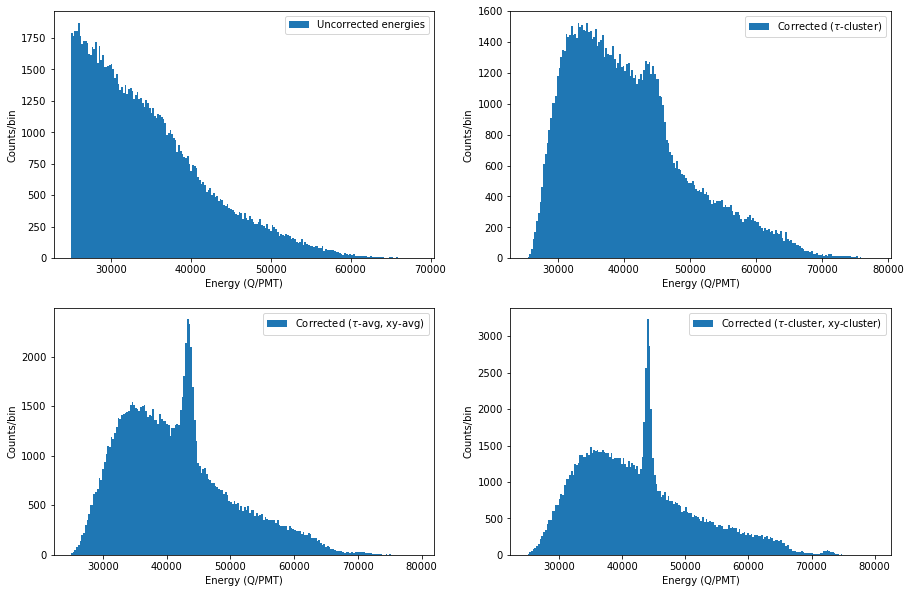

In [64]:
cuts_espectra = C_basic
ebins = 200

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(A_E0[cuts_espectra]/npmts,bins=ebins,label='Uncorrected energies')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(A_Ec_tau[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-cluster)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(A_Ec_avg[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-avg, xy-avg)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(A_Ec[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-cluster, xy-cluster)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

## Paolina track and voxel distributions

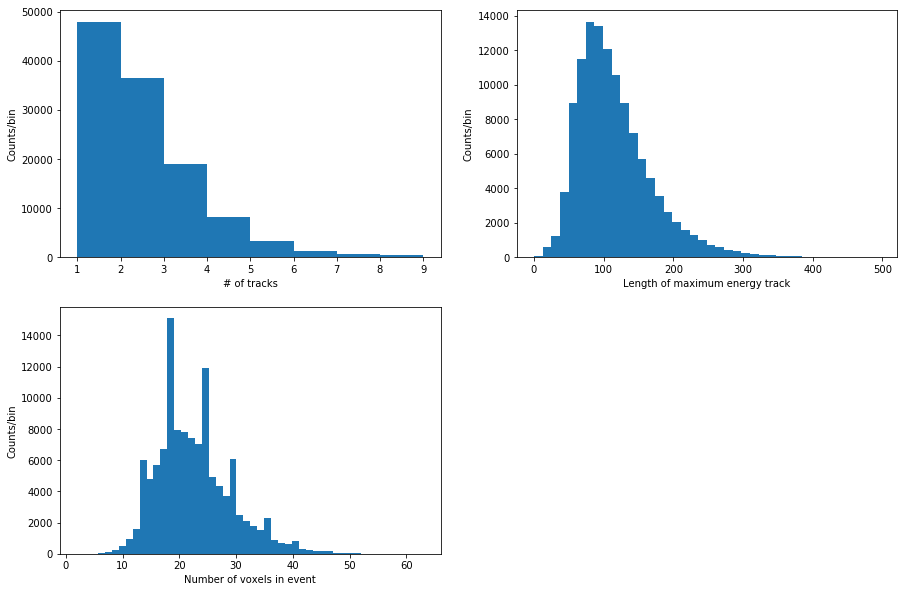

In [65]:
cuts_trkplots = C_basic
ntrk_bins = 8
lmtrk_bins = 40
nvox_bins = 50

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(A_ntrks[cuts_trkplots],bins=ntrk_bins)
plt.xlabel('# of tracks')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(A_lmtrk[cuts_trkplots],bins=lmtrk_bins)
plt.xlabel('Length of maximum energy track')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(223)
plt.hist(A_nvox[cuts_trkplots],bins=nvox_bins)
plt.xlabel('Number of voxels in event')
plt.ylabel('Counts/bin')

## Blob energy plots

Number of events I1 (1033.33 keV, 1196.67 keV): 3923
Number of events I2 (1566.67 keV, 1656.67 keV): 5337
Number of events I3 (1733.33 keV, 2500.00 keV): 5817
Some long events in peak region above 300 keV (2-blobs):
[2013, 3962, 4153, 6411, 6948, 10355, 13364, 18413, 20054, 20448, 20449, 20864, 20901, 25103, 25738, 26366, 27590, 39471, 41627, 44007]
Some long events in peak region 40 <= Eblob <= 200 keV (1-blob):
[420, 441, 451, 580, 774, 776, 1106, 1677, 1730, 2040, 2198, 2253, 2283, 2666, 2814, 3184, 3557, 3856, 4106, 4360]


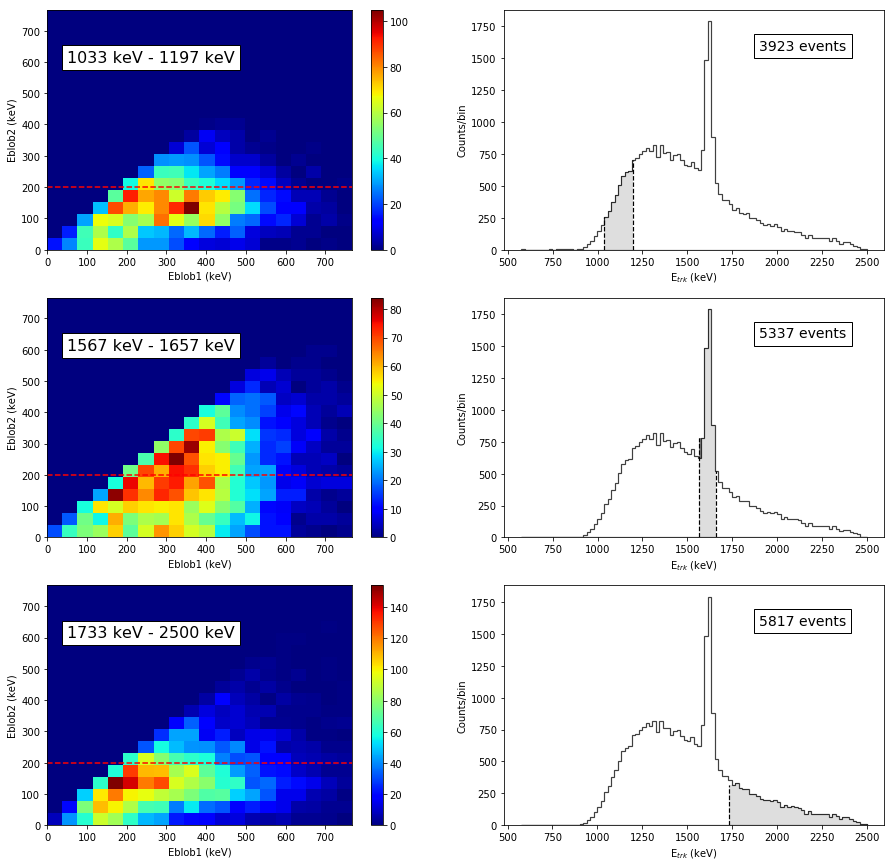

In [66]:
# Plot Eblob1 vs. Eblob2 in several intervals
nbins_blobs = 20

fig = plt.figure(3)
fig.set_figheight(15.0)
fig.set_figwidth(15.0)

# axes
ax_low = 15000; ax_high = 195000

# histogram range
hrange = 230000

# label locations
label_blobhist_x = 50
label_blobhist_y = 600
label_evthist_x = 1900

# horizontal reference line
hline_y = 200

# cuts
cuts_1 = C_emtrk_regionprepeak
cuts_2 = C_emtrk_regionpeak
cuts_3 = C_emtrk_regionpostpeak

print("Number of events I1 ({0:.2f} keV, {1:.2f} keV): {2}".format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR,len(A_eblob1[cuts_1])))
print("Number of events I2 ({0:.2f} keV, {1:.2f} keV): {2}".format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR,len(A_eblob1[cuts_2])))
print("Number of events I3 ({0:.2f} keV, {1:.2f} keV): {2}".format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR,len(A_eblob1[cuts_3])))

pltevts_2e = cuts_2 & (A_eblob2*CAL_FACTOR > 300) & (A_lmtrk > 180)
pltevts_1e = cuts_2 & (A_eblob2*CAL_FACTOR >= 40) & (A_eblob2*CAL_FACTOR <= 200) & (A_lmtrk > 180)
print("Some long events in peak region above 300 keV (2-blobs):")
print([i for i,x in enumerate(pltevts_2e) if x][0:20])
print("Some long events in peak region 40 <= Eblob <= 200 keV (1-blob):")
print([i for i,x in enumerate(pltevts_1e) if x][0:20])

# -----------------------------------------------
# interval 1
ax1 = fig.add_subplot(321)
hxy, xxy, yxy = np.histogram2d(A_eblob2[cuts_1]*CAL_FACTOR, A_eblob1[cuts_1]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax1.text(label_blobhist_x, label_blobhist_y, '{0:.4g} keV - {1:.4g} keV'.format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax1.set_xlabel("Eblob1 (keV)")
ax1.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp1)

ax2 = fig.add_subplot(322)
n, bins, patches = plt.hist(A_emtrk[C_basic_emtrk]*CAL_FACTOR,bins=100,histtype='stepfilled')
plt.setp(patches, 'facecolor', 'w', 'edgecolor', 'black', 'linewidth', 1.2, 'alpha', 0.75);
low_cut = eb1_low*CAL_FACTOR
high_cut = eb1_high*CAL_FACTOR
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)
ax2.text(label_evthist_x, 7*max(n)/8, '{0} events'.format(len(A_eblob1[cuts_1])), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=14)
ax2.set_xlabel('E$_{trk}$ (keV)')
ax2.set_ylabel('Counts/bin')

# -----------------------------------------------
# interval 2
ax3 = fig.add_subplot(323)
hxy, xxy, yxy = np.histogram2d(A_eblob2[cuts_2]*CAL_FACTOR, A_eblob1[cuts_2]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax3.text(label_blobhist_x, label_blobhist_y, '{0:.4g} keV - {1:.4g} keV'.format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent3 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp3 = ax3.imshow(hxy, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax3.set_xlabel("Eblob1 (keV)")
ax3.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp3)

ax4 = fig.add_subplot(324)
n, bins, patches = plt.hist(A_emtrk[C_basic_emtrk]*CAL_FACTOR,bins=100,histtype='stepfilled')
plt.setp(patches, 'facecolor', 'w', 'edgecolor', 'black', 'linewidth', 1.2, 'alpha', 0.75);
low_cut = eb2_low*CAL_FACTOR
high_cut = eb2_high*CAL_FACTOR
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)
ax4.text(label_evthist_x, 7*max(n)/8, '{0} events'.format(len(A_eblob1[cuts_2])), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=14)
ax4.set_xlabel('E$_{trk}$ (keV)')
ax4.set_ylabel('Counts/bin')

# -----------------------------------------------
# interval 3
ax5 = fig.add_subplot(325)
hxy, xxy, yxy = np.histogram2d(A_eblob2[cuts_3]*CAL_FACTOR, A_eblob1[cuts_3]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax5.text(label_blobhist_x, label_blobhist_y, '{0:.4g} keV - {1:.4g} keV'.format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent5 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp5 = ax5.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax5.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax5.set_xlabel("Eblob1 (keV)")
ax5.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp5)

ax6 = fig.add_subplot(326)
n, bins, patches = plt.hist(A_emtrk[C_basic_emtrk]*CAL_FACTOR,bins=100,histtype='stepfilled')
plt.setp(patches, 'facecolor', 'w', 'edgecolor', 'black', 'linewidth', 1.2, 'alpha', 0.75);
low_cut = eb3_low*CAL_FACTOR
high_cut = eb3_high*CAL_FACTOR
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)
ax6.text(label_evthist_x, 7*max(n)/8, '{0} events'.format(len(A_eblob1[cuts_3])), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=14)
ax6.set_xlabel('E$_{trk}$ (keV)')
ax6.set_ylabel('Counts/bin')

## Radial and z distributions

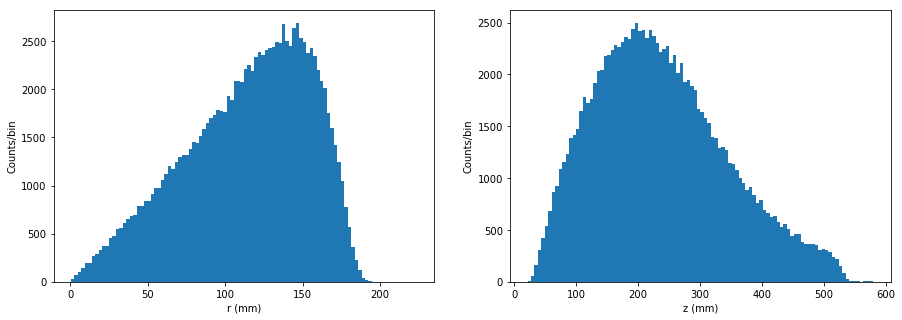

In [67]:
# Distributions in r and z
cuts_rz = C_basic


fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# event distribution in R
ax1 = fig.add_subplot(121);
plt.hist(A_ravg[cuts_rz],bins=100)
plt.xlabel('r (mm)')
plt.ylabel('Counts/bin')

# event distribution in z
ax2 = fig.add_subplot(122);
plt.hist(A_zavg[cuts_rz],bins=100)
plt.xlabel('z (mm)')
plt.ylabel('Counts/bin')

## x-y distribution

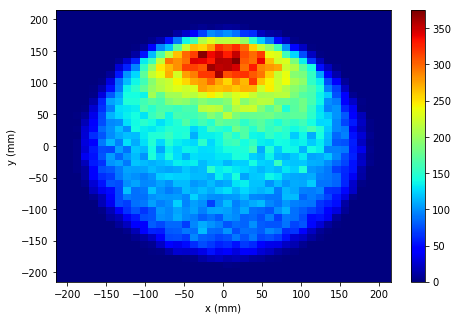

In [68]:
# Distribution in x-y
cuts_xy = C_basic
nxybins = 40

fig = plt.figure(1);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

# correction factor
plt.hist2d(A_xavg[cuts_xy], A_yavg[cuts_xy], (nxybins, nxybins), ((-215, 215), (-215, 215)), cmap='jet')
plt.colorbar()
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

## Energy spectrum (double-escape peak)

/Users/jrenner/IFIC/IC-1/invisible_cities/core/fit_functions.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))


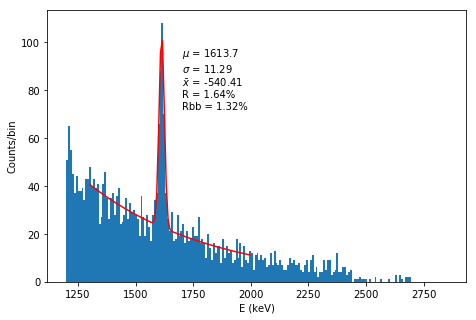

In [121]:
# Energy spectrum, focusing on double-escape peak
cuts_espec = C_tight

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

y0, x0, _ = plt.hist(A_Ec[cuts_espec]*CAL_FACTOR, 200, range=[1200,2850])

# Gaussian + exponential fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, 1300, 2000)
x, y = x[sel], y0[sel]
f    = fitf.fit(gaussexpo, x, y, (550, 1600, 100, 20, -600, 1200))
plt.plot(x, f.fn(x), "r")
plt.text(510000*CAL_FACTOR, 4*max(y)/6, gaussexpotext(f.values))

# Gaussian fit
#f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
#plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

## Blob cut efficiency

/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


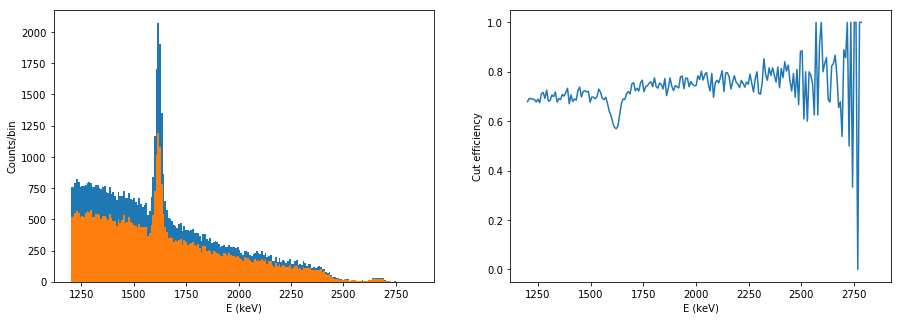

In [130]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
y0, x0, _ = plt.hist(A_Ec[C_wide]*CAL_FACTOR, 200, range=[1200,2850])
y1, x1, _ = plt.hist(A_Ec[C_widewblobs]*CAL_FACTOR, 200, range=[1200,2850])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

eng = []; eff = []
for xv0,yv0,xv1,yv1 in zip(x0,y0,x1,y1):
    eng.append(xv0)
    eff.append(yv1/yv0)

ax1 = fig.add_subplot(122);
plt.plot(eng,eff)
plt.xlabel('E (keV)')
plt.ylabel('Cut efficiency')

## Energy spectrum (2.6 MeV peak)

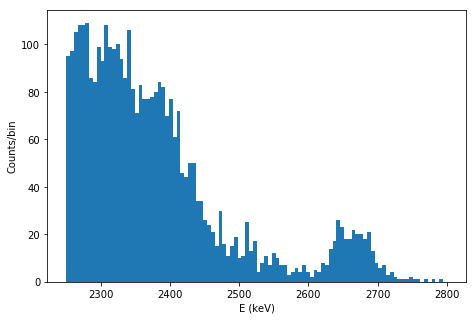

In [33]:
# Energy spectrum, focusing on 2.6 MeV peak
cuts_peak2pt6 = C_wide

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

y, x, _ = plt.hist(A_Ec[cuts_peak2pt6]*CAL_FACTOR, 100, range=[2250,2800])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

## Time evolution of energy

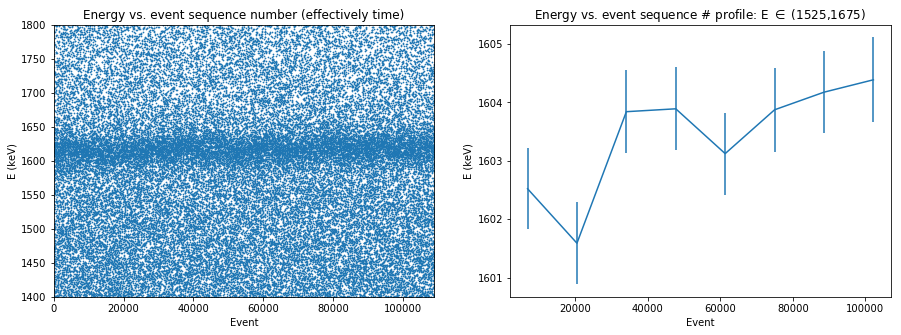

In [34]:
# Energy vs. event (effectively "time")
cuts_time = C_basic

Ehist_min = 1525
Ehist_max = 1675
enseq = np.array(range(len(A_Ec[cuts_time])))
tprof, Eprof, Eerr = fitf.profileX(enseq,A_Ec[cuts_time]*CAL_FACTOR,nbins=8,xrange=(0,109000),yrange=(Ehist_min,Ehist_max))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
ax1.scatter(enseq,A_Ec[cuts_time]*CAL_FACTOR,s=0.5)
plt.title("Energy vs. event sequence number (effectively time)")
plt.ylim([1400,1800])
plt.xlim([0,109000])
plt.xlabel('Event')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122)
ax2.errorbar(tprof,Eprof,yerr=Eerr)
plt.title("Energy vs. event sequence # profile: E $\in$ ({0},{1})".format(Ehist_min,Ehist_max))
plt.xlabel('Event')
plt.ylabel('E (keV)')

## Energy as a function of z

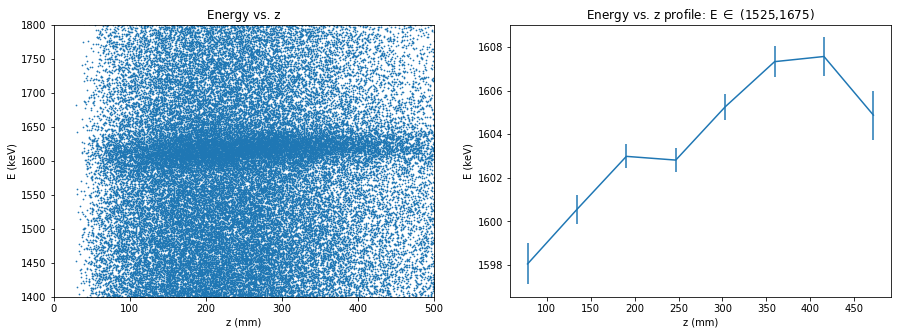

In [116]:
# Energy vs. z
cuts_z = C_basic

Ehist_min = 1525
Ehist_max = 1675
zprof, Eprof, Eerr = fitf.profileX(A_zavg[cuts_z],A_Ec[cuts_z]*CAL_FACTOR,nbins=8,xrange=(50,500),yrange=(Ehist_min,Ehist_max))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
ax1.scatter(A_zavg[cuts_z],A_Ec[cuts_z]*CAL_FACTOR,s=0.5)
plt.title("Energy vs. z")
plt.ylim([1400,1800])
plt.xlim([0,500])
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122);
ax2.errorbar(zprof,Eprof,yerr=Eerr)
plt.title("Energy vs. z profile: E $\in$ ({0},{1})".format(Ehist_min,Ehist_max))
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

## Energy as a function of r

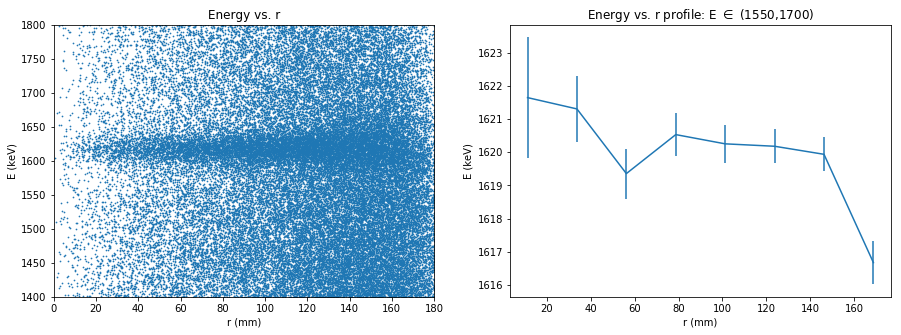

In [117]:
# Energy vs. z
cuts_r = C_basic

Ehist_min = 1550
Ehist_max = 1700
rprof, Eprof, Eerr = fitf.profileX(A_ravg[cuts_r],A_Ec[cuts_r]*CAL_FACTOR,nbins=8,xrange=(0,180),yrange=(Ehist_min,Ehist_max))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
ax1.scatter(A_ravg[cuts_r],A_Ec[cuts_r]*CAL_FACTOR,s=0.5)
plt.title("Energy vs. r")
plt.ylim([1400,1800])
plt.xlim([0,180])
plt.xlabel('r (mm)')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122);
ax2.errorbar(rprof,Eprof,yerr=Eerr)
plt.title("Energy vs. r profile: E $\in$ ({0},{1})".format(Ehist_min,Ehist_max))
plt.xlabel('r (mm)')
plt.ylabel('E (keV)')

## Resolution as a function of z

/Users/jrenner/IFIC/IC-1/invisible_cities/core/fit_functions.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))


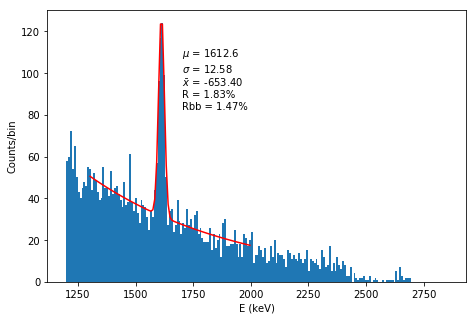

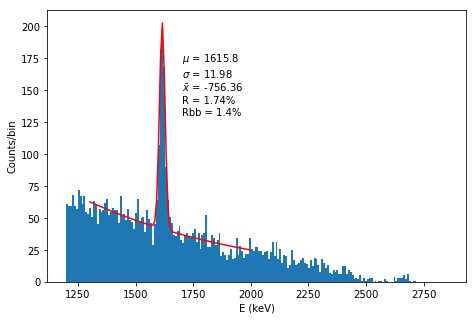

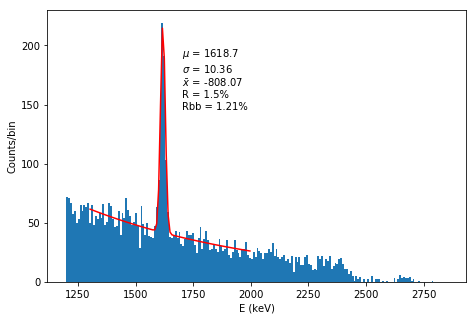

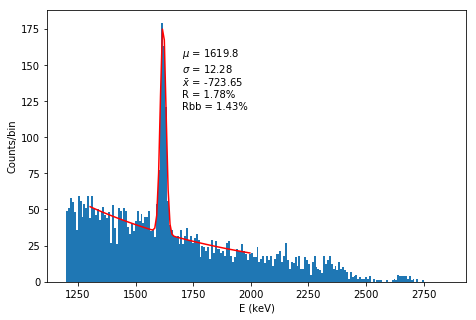

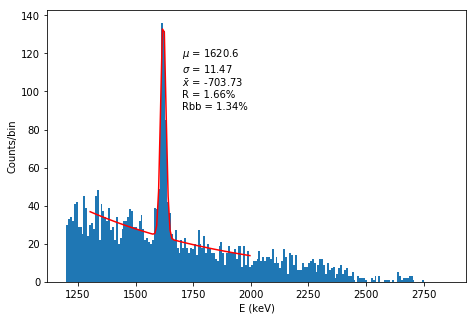

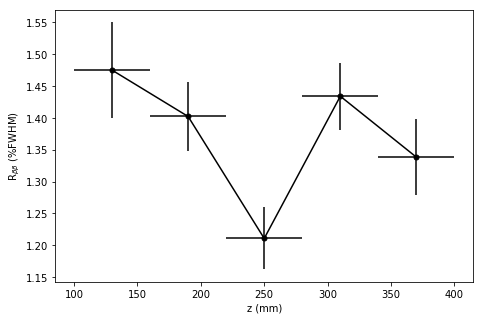

In [113]:
zlow = 100; zhigh = 400
zbins = 5

zbcenter = []; res = []; err_res = []
zbsize = (zhigh - zlow)/zbins
for nb in range(zbins):
    
    zl = zlow + nb*zbsize
    zh = zlow + (nb+1)*zbsize
    cuts_rvsz = C_basic & (A_ntrks < 5) & (A_lmtrk > 50) & (A_zavg >= zl) & (A_zavg < zh) & (A_ravg < 100)

    # Energy spectrum, focusing on double-escape peak
    fig = plt.figure()
    fig.set_figheight(5.0)
    fig.set_figwidth(7.5)

    y0, x0, _ = plt.hist(A_Ec[cuts_rvsz]*CAL_FACTOR, 200, range=[1200,2850])

    # Gaussian + exponential fit
    x    = x0[:-1] + np.diff(x0) * 0.5
    sel  = coref.in_range(x, 1300, 2000)
    x, y = x[sel], y0[sel]
    f    = fitf.fit(gaussexpo, x, y, (500, 1620, 20, 20, -600, 1200))
    plt.plot(x, f.fn(x), "r")
    plt.text(510000*CAL_FACTOR, 4*max(y)/6, gaussexpotext(f.values))
    
    # Record the resolution
    R,Rbb = reso(f.values[0:3])
    err_R,err_Rbb = reso_errors(f.values[0:3],f.errors[0:3])
    zbcenter.append((zh+zl)/2)
    res.append(Rbb)
    err_res.append(err_Rbb)

    plt.xlabel('E (keV)')
    plt.ylabel('Counts/bin')
    
    plt.savefig("espectrum_zl_{0}_zh_{1}.pdf".format(zl,zh))
    
# Plot resolution vs. z
fig = plt.figure()
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.errorbar(zbcenter,res,marker='.',c='black',markersize=10,yerr=err_res,xerr=zbsize/2.)
plt.xlabel('z (mm)')
plt.ylabel('R$_{\\beta\\beta}$ (%FWHM)')

## Resolution as a function of R

/Users/jrenner/IFIC/IC-1/invisible_cities/core/fit_functions.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))


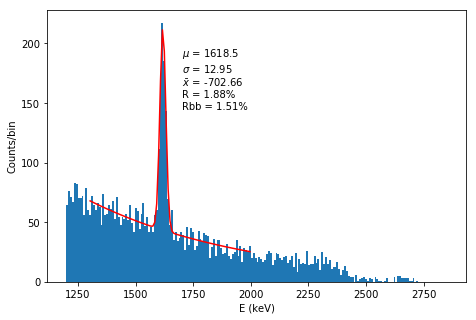

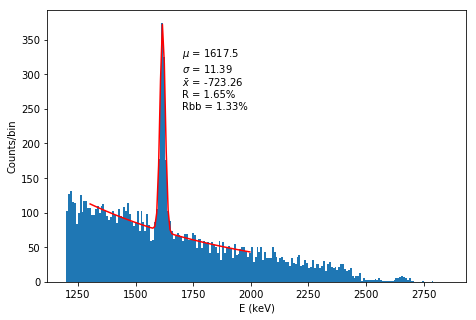

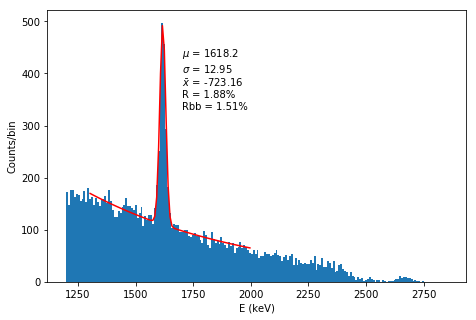

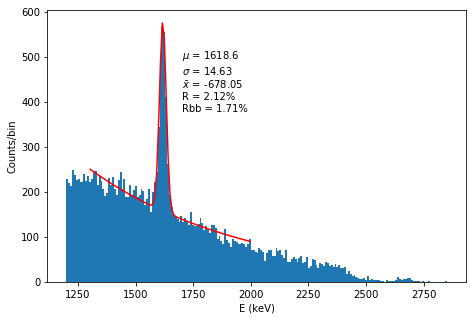

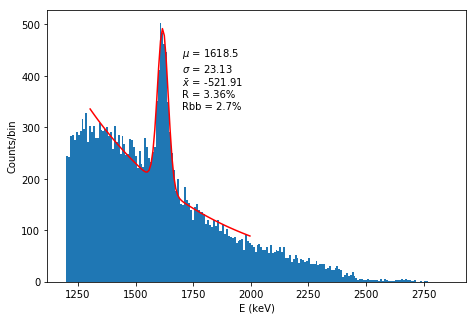

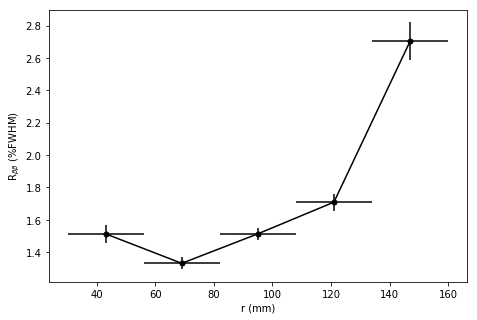

In [114]:
rlow = 30; rhigh = 160
rbins = 5

rbcenter = []; res = []; err_res = []
rbsize = (rhigh - rlow)/rbins
for nb in range(rbins):
    
    rl = rlow + nb*rbsize
    rh = rlow + (nb+1)*rbsize
    cuts_rvsr = C_basic & (A_ntrks < 5) & (A_lmtrk > 50) & (A_ravg >= rl) & (A_ravg < rh) & (A_zavg > 50) & (A_zavg < 500)

    # Energy spectrum, focusing on double-escape peak
    fig = plt.figure()
    fig.set_figheight(5.0)
    fig.set_figwidth(7.5)

    y0, x0, _ = plt.hist(A_Ec[cuts_rvsr]*CAL_FACTOR, 200, range=[1200,2850])

    # Gaussian + exponential fit
    x    = x0[:-1] + np.diff(x0) * 0.5
    sel  = coref.in_range(x, 1300, 2000)
    x, y = x[sel], y0[sel]
    f    = fitf.fit(gaussexpo, x, y, (500, 1620, 30, 20, -600, 1200))
    plt.plot(x, f.fn(x), "r")
    plt.text(510000*CAL_FACTOR, 4*max(y)/6, gaussexpotext(f.values))
    
    # Record the resolution
    R,Rbb = reso(f.values[0:3])
    err_R,err_Rbb = reso_errors(f.values[0:3],f.errors[0:3])
    rbcenter.append((rh+rl)/2)
    res.append(Rbb)
    err_res.append(err_Rbb)
    
    plt.xlabel('E (keV)')
    plt.ylabel('Counts/bin')
    
    plt.savefig("espectrum_rl_{0}_rh_{1}.pdf".format(rl,rh))
    
# Plot resolution vs. z
fig = plt.figure()
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.errorbar(rbcenter,res,marker='.',c='black',markersize=10,yerr=err_res,xerr=rbsize/2.)
plt.xlabel('r (mm)')
plt.ylabel('R$_{\\beta\\beta}$ (%FWHM)')

-----------------------

# Plots of individual tracks

In [ ]:
nevt = 3962

#Some long events in peak region above 300 keV (2-blobs):
#[2013, 3962, 4249, 5453, 6411, 6948, 7538, 8579, 10355, 10930, 10964, 11225, 13364, 18413, 20054, 20448, 20449, 20901, 25738, 26366]
#Some long events in peak region 40 <= Eblob <= 200 keV (1-blob):
#[72, 161, 451, 580, 645, 776, 1106, 1364, 1504, 1677, 1730, 1929, 2029, 2040, 2198, 2253, 2283, 2666, 2792, 2814]

# Get the corrected hits for this event.
hitc = hitc_cevt[nevt]
print("Running Paolina for event {0} with blob radius {1}".format(nevt,blob_radius))

evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(nevt,evt_E*CAL_FACTOR))

# Make the tracks.
voxels = plf.voxelize_hits(hitc,vox_size)
trks = plf.make_track_graphs(voxels,vox_size)
l_etrks_all = []
for t in trks:
    if(len(t.nodes()) < 1):
        etrk = 0
    else:
        etrk = sum([vox.E for vox in t.nodes()])
    l_etrks_all.append(etrk)

# "max" track is the one with the most energy.
itmax = np.argmax(l_etrks_all) 
etmax = sum([vox.E for vox in trks[itmax].nodes()])

# Construct the blobs.
eblobs = plf.blob_energies(trks[itmax],blob_radius)
iter_eblobs = iter(eblobs)
Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

# Ensure blob1 always has higher energy.
if(Eblob2 > Eblob1):
    eswap = Eblob1
    Eblob1 = Eblob2
    Eblob2 = eswap

# Get the extremes.
distances = plf.shortest_paths(trks[itmax])
a,b = plf.find_extrema(distances)
ltrk = distances[a][b]
print("Found {0} tracks; max containing {1} voxels; total of {2} voxels, distance = {3}".format(len(trks),len(trks[itmax]),len(voxels),distances[a][b]))
    
# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
#for vv in trks[itmax]:
for vv in voxels:
    varr_x.append(vv.pos[0])
    varr_y.append(vv.pos[1])
    varr_z.append(vv.pos[2])
    varr_c.append(vv.E*CAL_FACTOR)
    
vtrk_max = 1.0*np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = 1.0*np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])
vtrk_len = np.abs(vtrk_max-vtrk_min)
vtrk_max = vtrk_max + 3.0*vox_size
vtrk_min = vtrk_min - 3.0*vox_size

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_xlim([vtrk_min[0],vtrk_max[0]])
ax1.set_ylim([vtrk_min[1],vtrk_max[1]])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (keV)')
ax1.scatter(a.pos[0],a.pos[1],marker='x',s=200,color='red')
ax1.scatter(b.pos[0],b.pos[1],marker='x',s=200,color='red')
ax1.text(vtrk_min[0]+vox_size[0]/4, 6*vtrk_max[1]/7, "Eb$_1$ = {0:.0f} keV, Eb$_2$ = {1:.0f} keV\nL = {2:.0f} mm".format(Eblob1*CAL_FACTOR,Eblob2*CAL_FACTOR,ltrk), 
         color='white',fontsize=14,weight='bold')

# Create the y-z projection.
ax2 = fig.add_subplot(132)
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_xlim([vtrk_min[1],vtrk_max[1]])
ax2.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp2 = plt.colorbar(sp2)
cbp2.set_label('Energy (keV)')
ax2.scatter(a.pos[1],a.pos[2],marker='x',s=200,color='red')
ax2.scatter(b.pos[1],b.pos[2],marker='x',s=200,color='red')

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_xlim([vtrk_min[0],vtrk_max[0]])
ax3.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (keV)');
ax3.scatter(a.pos[0],a.pos[2],marker='x',s=200,color='red')
ax3.scatter(b.pos[0],b.pos[2],marker='x',s=200,color='red')

print("Extreme0 at ({0},{1},{2}) with energy {3} keV".format(a.pos[0],a.pos[1],a.pos[2],Eblob1*CAL_FACTOR))
print("Extreme1 at ({0},{1},{2}) with energy {3} keV".format(b.pos[0],b.pos[1],b.pos[2],Eblob2*CAL_FACTOR))

## Affect of blob cuts on spectrum

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(A_Ec[A_eblob2 < 300/CAL_FACTOR],bins=150,label='Single-track')
plt.hist(A_Ec[A_eblob2 > 300/CAL_FACTOR],bins=150,alpha=0.5,label='Double-track')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

------------------------------------------------------------------

# Lifetime check

In [ ]:
rnum = 4607
CAL_FACTOR = 0.0033
ctau_Emin = 1000/CAL_FACTOR; ctau_Emax = 2000/CAL_FACTOR

In [ ]:
fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks_{1}.h5".format(rnum,rnum)
hits_all = load_hits(fname)
hits = load_hits_skipping_NN(fname)

# Modifies the list of non-NN hits.
merge_NN_hits(hits_all,hits)

In [ ]:
#l_taulife = np.arange(1087,1887,100)  # run 4595
#l_taulife = np.arange(1038,1838,100)  # run 4597
#l_taulife = np.arange(1056,1856,100)  # run 4599
#l_taulife = np.arange(1060,1860,100)  # run 4601
#l_taulife = np.arange(1055,1855,100)  # run 4603
#l_taulife = np.arange(1063,1863,100)  # run 4605
l_taulife = np.arange(1088,1888,100)  # run 4607

In [ ]:
# For each lifetime, perform the correction and fit.
l_emean = []; l_eres = []
for tlife in l_taulife:
    
    hitc_ctau = [] 
    etau_spec = []; e0tau_spec = []; ztau_spec = []; rtau_spec = []
    for ee,hc in hits.items():
        hc_corr = []
        evt_E = 0; evt_E0 = 0 
        evt_X = 0; evt_Y = 0; evt_Z = 0
        for hh in hc.hits:
            hecorr = hh.E*fcorr(hh.X,hh.Y)/np.exp(-hh.Z/tlife)
            hcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
            hc_corr.append(hcorr)
            evt_E += hecorr
            evt_E0 += hh.E
            evt_X += hh.X*hh.E
            evt_Y += hh.Y*hh.E
            evt_Z += hh.Z*hh.E

        # Compute event energy.
        if(evt_E > 0):
            evt_X /= evt_E
            evt_Y /= evt_E
            evt_Z /= evt_E
        evt_R = np.sqrt(evt_X**2 + evt_Y**2)
        if(evt_E > ctau_Emin and evt_E < ctau_Emax):
            etau_spec.append(evt_E*CAL_FACTOR)
            rtau_spec.append(evt_R)
            e0tau_spec.append(evt_E0)
            ztau_spec.append(evt_Z)
        
        hitc_ctau.append(hc_corr)
    
    etau_spec = np.array(etau_spec)
    rtau_spec = np.array(rtau_spec)
    e0tau_spec = np.array(e0tau_spec)
    ztau_spec = np.array(ztau_spec)
        
    # Perform the fit.
    fig = plt.figure()
    fig.set_figheight(5.0)
    fig.set_figwidth(7.5)    
    y, x, _ = plt.hist(etau_spec[(rtau_spec < 150)], 150, range=[1200,2000])
    x    = x[:-1] + np.diff(x) * 0.5
    sel  = fitf.in_range(x, 1400, 1800)
    x, y = x[sel], y[sel]
    f    = fitf.fit(gaussexpo, x, y, (550, 1600, 100, 50, -600, 1200))
    plt.plot(x, f.fn(x), "r")
    plt.text(510000*CAL_FACTOR, 4*max(y)/6, gaussexpotext(f.values))
    plt.savefig("fit_run_{0}_tlife_{1}.pdf".format(rnum,tlife))
    
    # Save the mean and resolution.
    mu = f.values[1]; sigma = f.values[2]
    res = 235. * sigma/mu
    l_emean.append(mu)
    l_eres.append(res)
    
    print("[Lifetime {0} mus] mean = {1}, resolution = {2} %FWHM; mean correction factor = {3}".format(tlife,mu,res,1590./mu))

---------------------